<a href="https://colab.research.google.com/github/daorhe2272/analisis_de_datos_I/blob/main/Taller_3_An%C3%A1lisis_de_Datos_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 3: Comparte tu análisis Bivariado**

Para consultar el problema y la pregunta SMART que se trata de responder, [favor ver este enlace](https://github.com/daorhe2272/analisis_de_datos_I/blob/main/taller_1.ipynb).

El siguiente set de datos corresponde a la rotación por producto de los últimos 3 meses de una empresa que comercializa productos de consumo masivo no perecederos:

In [1]:
# Primero cargamos los datos
import pandas as pd
import numpy as np

data_url = "https://raw.githubusercontent.com/daorhe2272/analisis_de_datos_I/main/query_results.json"

df = pd.read_json(data_url)
df.head()

,Activo,Categorias,_id,Codigo,Descripcion,Marca,Unidad_venta,Stock,Costo,Precio_base,Rotacion_actual,Rotacion_mes,Rotacion_bimestre,Rotacion_trimestre,Comprado,Fecha_compra,iva,Descripcion_full
0,True,"[Papel regalos, seda, crepé, craft]",63e570ea6aa0ed10c8a8340b,1375,PAPEL CELOFAN AMARILLO 96X100,AFA DIST,UNIDAD,499,314,440,0,530,660,1210,4000,20231204,19,Papel celofan amarillo 96x099
1,False,[Otros cacharrería],63e570ea6aa0ed10c8a833e3,1003,INGRESO PARA TERCEROS (22937),BELLEZA,UNID.,0,1,1380000,0,0,0,0,0,20200210,0,Ingreso para terceros
2,False,[Cuadernos y agendas],63e570ea6aa0ed10c8a833ed,7861084254023,CUAD.LINEA AZUL 85-100-1 STIKER,A&C ESCO,UNID.,0,1450,1800,0,4,4,4,300,20190215,0,Cuaderno Línea Azul con stickers argollado peq...
3,True,[Bombillos],63e570ea6aa0ed10c8a83467,7703255298989,BOMBILLO NALPILUX LED 5W,PANASONI,UNIDAD,130,2285,2800,22,66,166,166,100,20240822,19,Bombillo Nalpilux led 5w
4,False,[Enjuages bucales],63e570ea6aa0ed10c8a83487,037000956662,ENJ.CREST SCOPE OUTLAST X500ML,PREBEL,UNIDAD,0,10042,11520,0,0,0,0,3,20230118,19,Enjuague bucal crest scope outlast de 500 ml


Para este análisis bivariado nos concentraremos principalmente en dos variables:


1.   La rotación mensual por producto
2.   La categoría a la que pertenece dicho producto



In [2]:
# Primero, descartamos las filas de productos sin una categoría
# En este caso estamos asumiendo que los valores faltantes son MCAR

df = df[df['Categorias'].apply(lambda x: len(x) > 0)]

In [3]:
# Ahora usamos la función explode para duplicar las filas de artículos con más de una categoría
df = df.explode("Categorias")

In [4]:
# Verificamos rápidamente que no hayan quedado filas de productos sin su categoría
df["Categorias"].isna().sum() == 0

True

Retomando el trabajo avanzado en el taller 2, limpiamos y procesamos los datos de manera similar:

In [5]:
# Eliminamos las columnas que no necesitaremos en este análisis:
columns_to_drop = ["Activo","Marca","Costo","Rotacion_actual","Comprado","iva","Stock"]
df = df.drop(columns=columns_to_drop)

In [6]:
# Revisamos si hay valores nulos en las demás columnas
print("Valores nulos por columna:\n")
print(df.isnull().sum())

Valores nulos por columna:

Categorias            0
_id                   0
Codigo                0
Descripcion           0
Unidad_venta          0
Precio_base           0
Rotacion_mes          0
Rotacion_bimestre     0
Rotacion_trimestre    0
Fecha_compra          0
Descripcion_full      0
dtype: int64


In [7]:
# **NO CORRER ESTE PASO MÁS DE UNA VEZ**
# Para este análisis, ignoramos los productos cuya última compra fue hace más de 12 meses:

# Primero eliminamos las filas cuyo formato de fecha esté errado
df["Fecha_compra"] = df["Fecha_compra"].astype(str)
df = df[df["Fecha_compra"].str.len() == 8].copy()

df = df.dropna()
df = df[df['Fecha_compra'].str.startswith('20')]
df.shape

(10572, 11)

In [8]:
# Ahora removemos los productos comprados por última vez hace más de 1 año
from datetime import datetime, timedelta

df['Fecha_compra'] = pd.to_datetime(df['Fecha_compra'].astype(str), format='%Y%m%d')
now = datetime.now()
time_limit = now - timedelta(days=365)
df = df[df["Fecha_compra"] > time_limit]

df = df.reset_index(drop=True)

# Es normal que el DataFrame se reduzca a la mitad ya que hay productos que son descodificados,
# ofertas que ya no existen, o referencias que cambian de código de barras
df.shape

(5693, 11)

In [9]:
# Eliminamos los productos con una rotación trimestral acumulada menor a $100.000
# ya que no nos interesa pronosticar la demanda de este tipo de productos
# a la vez que limpiamos filas que aportan poca información
condition = (df["Rotacion_trimestre"] * df["Precio_base"]) >= 100000
df = df[condition].copy()
df.shape

(3433, 11)

Como puede apreciarse, el dataset original se ha reducido de 10.000 a 3.200 items. Sin embargo, es normal que el 20% de los productos hagan el 80% de la venta. En todo caso, es precisamente la demanda de los productos con mayor rotación la que nos interesa pronosticar.

In [10]:
# **NO CORRER ESTE PASO MÁS DE UNA VEZ**
# Convirtamos los datos de rotación acumulada bimestral y trimestral en rotación mensual:
df["Rotacion_trimestre"] = df["Rotacion_trimestre"] - df["Rotacion_bimestre"]
df["Rotacion_bimestre"] = df["Rotacion_bimestre"] - df["Rotacion_mes"]

In [11]:
# Renombramos las columnas de acuerdo al mes del año
from dateutil.relativedelta import relativedelta

mes_1 = (now - relativedelta(months=1)).strftime("%B")
mes_2 = (now - relativedelta(months=2)).strftime("%B")
mes_3 = (now - relativedelta(months=3)).strftime("%B")

df = df.rename(columns={
    "Rotacion_mes": mes_1,
    "Rotacion_bimestre": mes_2,
    "Rotacion_trimestre": mes_3
})

df.columns

Index(['Categorias', '_id', 'Codigo', 'Descripcion', 'Unidad_venta',
       'Precio_base', 'August', 'July', 'June', 'Fecha_compra',
       'Descripcion_full'],
      dtype='object')

In [12]:
# Finalmente revisamos que el tipo de datos se adapte a nuestras necesidades
df.dtypes

,0
Categorias,object
_id,object
Codigo,object
Descripcion,object
Unidad_venta,object
Precio_base,int64
August,int64
July,int64
June,int64
Fecha_compra,datetime64[ns]


# **Comienza el análisis bivariado...**

Hemos terminado con la fase general de limpieza y transformación de datos. Recordemos que las dos variables que nos interesan ahora son ventas mensuales y categorías de productos.

Para poder comparar los datos entre productos con niveles de rotación dispar, vamos a normalizar los datos convirtiendo los valores a proporciones usando el primer mes como referencia.
De esta manera, la rotación para cada producto en mayo será de 1.0 y, en este orden de ideas, una rotación de 0.8 en junio indicará una caída en ventas del 20% con respecto a mayo, ó una rotación de 1.2 en julio indicará un aumento del 20% de las ventas *con respecto a mayo* (no el mes inmediatemente anterior).

In [14]:
# Para cada producto, dividimos la rotación de cada mes por el mes de mayo:

# El primer paso consiste en imputar los productos con rotación cero en mayo
# con el valor mínimo de los otros meses (diferente de cero).
def replace_zero_with_min(row):
    non_zero_min = row[['June', 'July','August']][row[['June', 'July', 'August']] > 0].min()
    return non_zero_min if row['June'] == 0 else row['June']
df['June'] = df.apply(replace_zero_with_min, axis=1)

# Ahora sí podemos hacer la operación evitando obtener valores NaN
df["August"] = df["August"] / df["June"]
df["July"] = df["July"] / df["June"]
df["June"] = df["June"] / df["June"]

# Comprobamos que la transformación sea la esperada:
df.tail()

,Categorias,_id,Codigo,Descripcion,Unidad_venta,Precio_base,August,July,June,Fecha_compra,Descripcion_full
5642,Shampoo y acondicionadores,66c0aae5984cff0a9c0c9785,650240011832,SH.TIO NACHO ACLARANTE MANZ.X415ML,UNIDAD,32000,1.0,0.0,1.0,2024-08-15,Shampoo aclarante Tío Nacho Manzana de 415 ml
5644,Shampoo y acondicionadores,66c0ab10984cff0a9c0c9e59,7702113047219,AC.MUSS KIDS MANZANI.X 400ML.,UNIDAD,18550,1.0,0.0,1.0,2024-08-27,Acondicionador Muss Manzanilla de 400 ml
5659,Colonias y lociones,66cc9e8d7073fa09f3a6885c,7702277086567,LOC.MENTICOL X130 ORIG.+ORIG.X60,OFERTA,10990,1.0,0.0,1.0,2024-08-24,LOC.MENTICOL X130 ORIG.+ORIG.X60
5660,Pañuelos y toallas humectantes,66cc9e8e7073fa09f3a68882,7702277212171,TOA.ARRU.AV.X270 (2X100 Y1X70),UNIDAD,24800,1.0,0.0,1.0,2024-08-24,TOA.ARRU.AV.X270 (2X100 Y1X70)
5664,Suplementos nutricionales,66cf490c6bc3fa097a1f989d,1799,TARRITO ROJO JGB X1200.5UN.GTS.2DP TRX25,OFERTA,298000,1.0,0.0,1.0,2024-08-27,TARRITO ROJO JGB X1200.5UN.GTS.2DP TRX25


In [15]:
len(df["Categorias"].unique())

104

In [16]:
# Tenemos más de 100 categorías de productos, por lo que es mejor concentrarnos en
# las 30 más representativas para este análisis bivariado
top_30 = df["Categorias"].value_counts().nlargest(30).index
df_reducido = df[df["Categorias"].isin(top_30)]

len(df_reducido["Categorias"].unique()) == 30

True

In [17]:
# Ahora convertimos la serie de tiempo en una sola columna para facilitar el análisis gráfico
df_reducido = pd.melt(df_reducido,
                  id_vars=['Categorias', '_id', 'Descripcion', 'Unidad_venta', 'Precio_base', 'Fecha_compra', 'Descripcion_full'],
                  value_vars=['August','July', 'June'],
                  var_name='Month',
                  value_name='Delta_ventas')
df_reducido.head()

,Categorias,_id,Descripcion,Unidad_venta,Precio_base,Fecha_compra,Descripcion_full,Month,Delta_ventas
0,"Papel regalos, seda, crepé, craft",63e570ea6aa0ed10c8a8340b,PAPEL CELOFAN AMARILLO 96X100,UNIDAD,440,2023-12-04,Papel celofan amarillo 96x099,August,0.963636
1,Deshodorantes,63e570eb6aa0ed10c8a834dd,DST.ELIZAB.CREM.X135G.X2 P/ESP.,UNIDAD,18500,2024-07-29,Desodorante en crema Elizabeth Arden de 135 gr...,August,1.000000
2,Jabones y gel antibacterial,63e570ef6aa0ed10c8a83847,JABON INTIB.SOB.X14G.X12UN.CAL.MUJ,DISPLEY,11700,2024-08-24,Jabón íntimo Intibon caléndula mujer de 14 gr ...,August,1.094972
3,Pilas y baterías,63e570ea6aa0ed10c8a83451,PILA PANAS.CTE.PNA.AA X 20,DISPLEY,16500,2024-08-16,Pila Panasonic corriente pequeña AA en tira de...,August,0.840659
4,Pilas y baterías,63e570ea6aa0ed10c8a8345f,PILA ECOBATTERY ALKAL.9V X1,UNIDAD,6720,2023-09-28,Pila Ecobattery alcalina 9V por unidad,August,0.159420


In [18]:
# Puesto que por cuestiones de agotados es posible que algunos productos
# tengan un valor de ventas muy bajo en el mes de mayo con respecto a
# otros valores, vamos a limitar el valor máximo para Delta_ventas a 10
df_reducido['Delta_ventas'] = df_reducido['Delta_ventas'].clip(upper=10)

df_reducido["Delta_ventas"].max() == 10

True

Ahora vamos a ver cómo han evolucionado las ventas mes a mes de los productos según su categoría. Hemos reducido nuestro dataset a 30 categorías, por lo que vamos a crear 3 gráficas con 10 categorías cada una.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

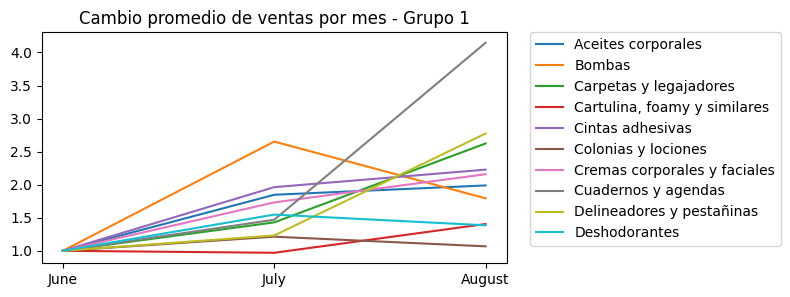

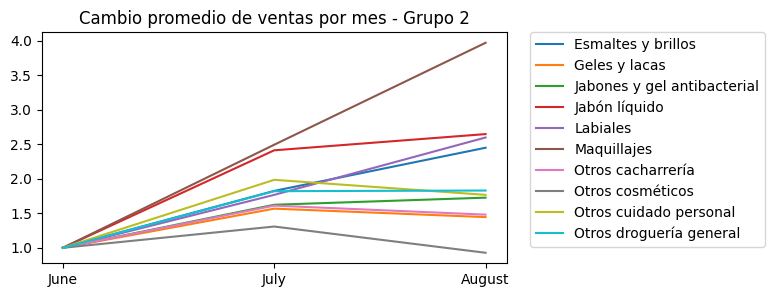

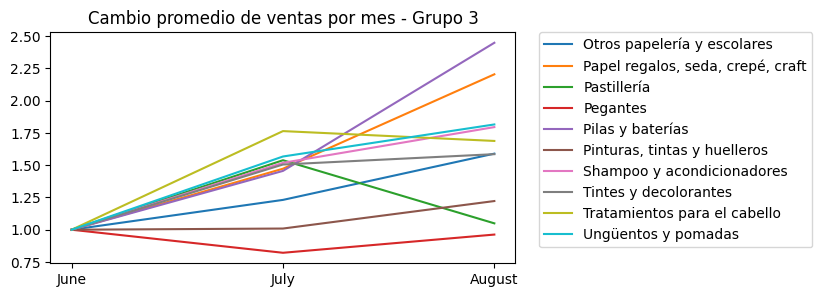

In [20]:
# Primero agrupamos los datos de acuerdo a la media de ventas por mes de cada categoría:
grupos = df_reducido.groupby(['Categorias', 'Month'])['Delta_ventas'].mean().reset_index()

# Definimos el orden de los meses
orden_meses = ['June', 'July','August']
grupos['Month'] = pd.Categorical(grupos['Month'], categories=orden_meses, ordered=True)

# Luego dividimos las agrupaciones en sub-grupos de a 10:
categorias = grupos['Categorias'].unique()
subgrupos = [categorias[i:i+10] for i in range(0, len(categorias), 10)]

# Finalmente creamos las 3 gráficas:
for i, group in enumerate(subgrupos, 1):
    plt.figure(figsize=(6, 3))

    for category in group:
        data = grupos[grupos['Categorias'] == category].sort_values('Month')
        plt.plot(data['Month'], data['Delta_ventas'], label=category)

    plt.title(f'Cambio promedio de ventas por mes - Grupo {i}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# **Conclusiones:**

Como podemos apreciar, los resultados son esperanzadores. El comportamiento de las ventas toma rutas divergentes según la categoría de cada producto. En otras palabras, la variable "Categorias" pareciera contener información relevante sobre el comportamiento de la venta, la cual es independiente del comportamiento general de las ventas mensuales (de lo contrario, las líneas del gráfico convergerían en una misma dirección).
De todas maneras debemos ser prudentes y reconocer que hemos introducido sezgos importantes en nuestros datos al imputar los valores nulos de ventas de mayo, y también al limitar el valor de los valores extremos a un número arbitrariamente escojido (diez).

**ANEXO:**
Como observación adicional, el análisis multivariado de los datos nos permite también construir un mapa de calor con la matriz de correlaciones de las diferentes categorías de productos usando el tiempo como índice. Aunque no es necesario para la pregunta SMART que guía esta investigación, sí es muy interesante observar cómo un aumento en la venta de ciertos productos afecta negativamente la venta de otros. Por ejemplo, es bien sabido por los distribuidores de cosméticos que los meses de enero y febrero son meses de muy pocas ventas, ya que gran parte del poder adquisitivo de las familias se empeña en la compra de artículos escolares y papelería. Una matriz de correlación como esta permitiría, de manera cuantitativa, identificar la relación entre ambos tipos de productos, además de permitirnos encontrar otras relaciones no tan obvias para el jefe de compras y demás directivos. Dejo a continuación una muestra del mapa de calor al que me refiero, construido con el dataset de este taller:

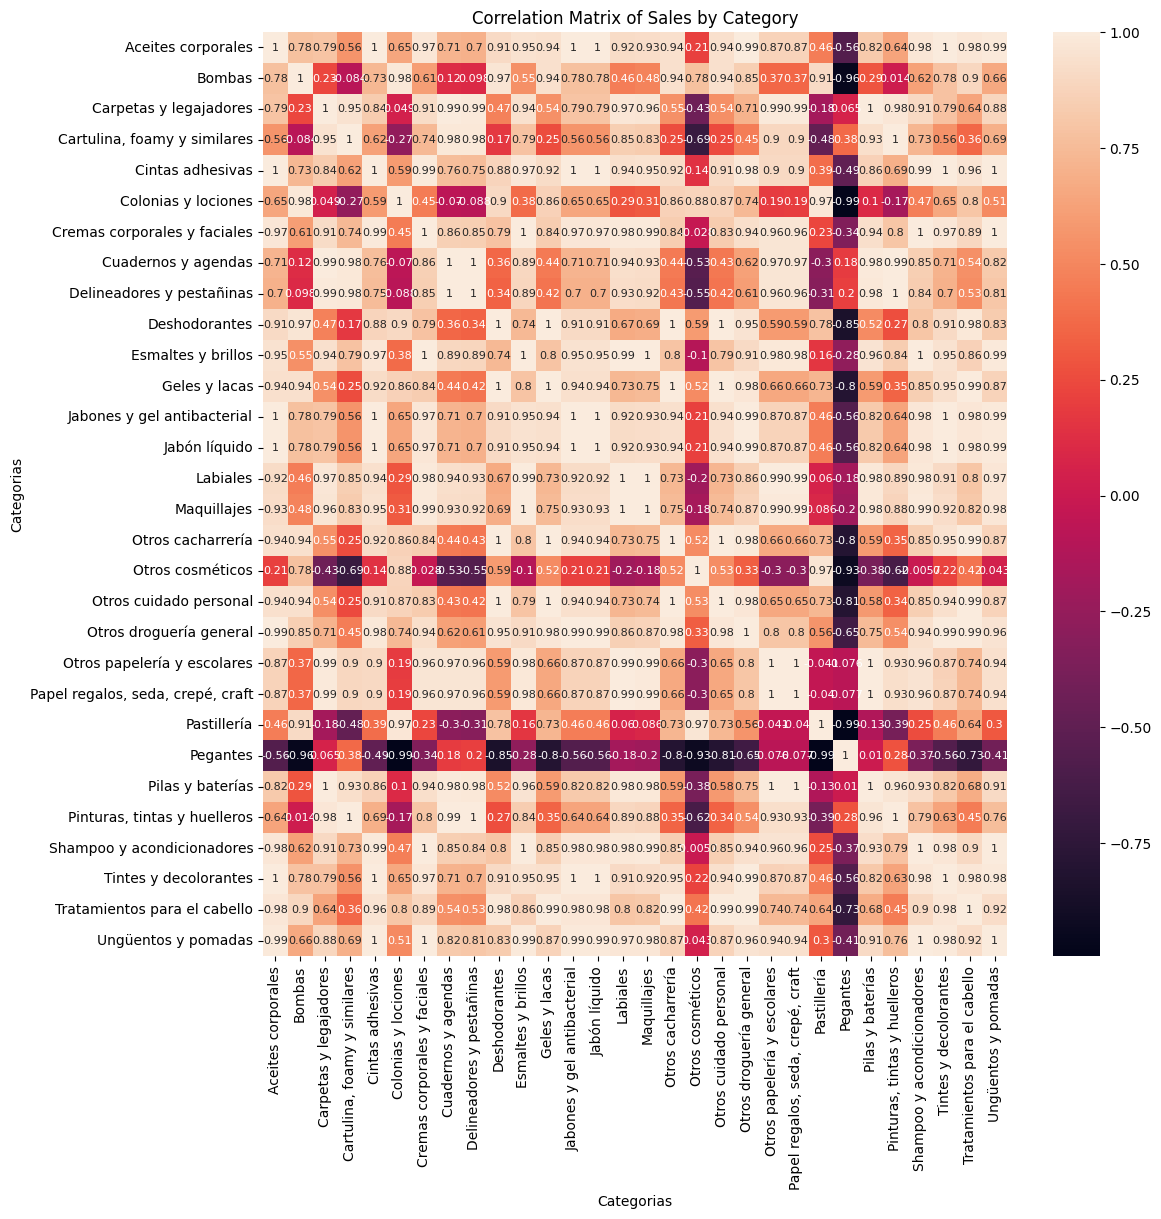

In [21]:
# Ahora revisamos de manera cuantitativa
# Mapa de calor de la matriz de correlaciones
plt.figure(figsize=(12, 12))
df_pivot = grupos.pivot_table(index='Month', columns='Categorias', values='Delta_ventas')
correlation = df_pivot.corr()
sns.heatmap(correlation, annot=True, annot_kws={"size": 8})
plt.title('Correlation Matrix of Sales by Category')
plt.show()